In [1]:
from my_methods import *

In [2]:
def represent_network(gene_list, dic, dist=0):    
    dic0 = dict(filter(lambda x: x[0] in gene_list, dic.items()))
    dic_f = {}
    for k in dic0.keys():
        dic_f[k] = dict(filter(lambda x: x[0] in gene_list, dic0[k].items()))
    if dist==1:
        proc = list(dic0.keys())
        for gene in proc: # gene es un gen del procesoma
            proc = list(dic0.keys())
            interactors = list(dic[gene].keys()) # todos los genes que interactuan con gene
            interactors = list(filter(lambda x: x not in proc, interactors)) # me quedo con los que no estan en proc
            proc.remove(gene)
            for i in interactors: # i es cada interactor de gene
                if len(set(dic[i].keys()).intersection(set(proc)))>0:
                    dic_f[i] = dict(filter(lambda x: x[0] in dic0.keys(), dic[i].items()))
                    for j in dic_f[i].keys():
                        dic_f[j][i] = dic[i][j]
    return dic_f

### Processome

In [3]:
dfE = pd.read_table('data/SGA_ExE.txt')
dfE = dfE.dropna()            # Elimino filas con NaN
dfE.reset_index(inplace=True, drop=True)
##################################
dfE['Mul'] = dfE['Double mutant fitness']-dfE['Query single mutant fitness (SMF)']*dfE['Array SMF']         # columna con interacciones mul
dfE['Add'] = dfE['Double mutant fitness']-(dfE['Query single mutant fitness (SMF)']+dfE['Array SMF']-1)     # columna con interacciones add
##################################
std_mul = dfE['Mul'].std()           # Desviaciones estandar de cada columna
std_add = dfE['Add'].std()
##################################
dfE['Query allele name'] = dfE['Query allele name'].map(lambda x: x.split('-')[0])        # Cambio de nombre
dfE['Array allele name'] = dfE['Array allele name'].map(lambda x: x.split('-')[0])
##################################
dfE = dfE.loc[dfE['P-value']<0.05]             # Filtro P-value
dfE.head()


########################################################################

def df_to_dictionary_splitted(csv, model, pvalue=1):
    df = csv.loc[csv[ 'P-value' ]<pvalue]
    df.reset_index(inplace=True, drop=True)
    query_dic = {}
    array_dic = {}
    for i in range(len(df)):
        if model == 'mul':
            interaction = df.loc[i, 'Double mutant fitness']-df.loc[i, 'Query single mutant fitness (SMF)']*df.loc[i, 'Array SMF']
        if model == 'add':
            interaction = df.loc[i, 'Double mutant fitness']-(df.loc[i, 'Query single mutant fitness (SMF)']+df.loc[i, 'Array SMF']-1)
        if not (np.isnan(interaction) or np.isinf(interaction)):
            query = df.loc[i, 'Query allele name']
            array = df.loc[i, 'Array allele name']
            ########################################################
            if query not in query_dic.keys():
                query_dic[query]={}
            if array not in query_dic[query].keys():
                query_dic[query][array]=interaction
            elif abs(interaction) > abs(query_dic[query][array]):
                query_dic[query][array]=interaction
            ########################################################
            if array not in array_dic.keys():
                array_dic[array]={}
            if query not in array_dic[array].keys():
                array_dic[array][query]=interaction
            elif abs(interaction) > abs(array_dic[array][query]):
                array_dic[array][query]=interaction
            ########################################################
    return query_dic, array_dic

########################################################################

qE, aE = df_to_dictionary_splitted(dfE, model='mul', pvalue=0.05)
ExE_mul = join_pcc(qE, aE)

qE, aE = df_to_dictionary_splitted(dfE, model='add', pvalue=0.05)
ExE_add = join_pcc(qE, aE)

########################################################################

for gene in ExE_mul.keys():
    ExE_mul[gene] = dict(filter(lambda x: abs(x[1])>2*std_mul, ExE_mul[gene].items()))

for gene in ExE_add.keys():
    ExE_add[gene] = dict(filter(lambda x: abs(x[1])>2*std_add, ExE_add[gene].items()))

########################################################################

potential_hubs0 = []
for gene in ExE_add.keys():
    try:
####### De aquellos genes con mas de 30 interactores en add se buscan los genes que en add tienen mas de 10 veces la cantidad de interactores predicha por mul
####### Busco los que en add tienen 10 veces mas interactores que en mul
        if len(ExE_add[gene])>30 and len(ExE_mul[gene]) > 0 and len(ExE_mul[gene]) < 0.1 * len(ExE_add[gene]):
            potential_hubs0.append(gene)
####### Busco los que en mul tienen 0 interactores y mas de 30
        if len(ExE_mul[gene]) == 0 and len(ExE_add[gene])>30:
            potential_hubs0.append(gene)
    except:
        pass
potential_hubs0 = list(set(potential_hubs0))
len(potential_hubs0)

########################################################################

table = pd.DataFrame(
    {'Candidate Hubs':[],
    '# of interactors (eM)':[],
    '# of interactors (eA)':[],
    '# of common interactors':[],
    }
)
for i in range(len(potential_hubs0)):
    gene = potential_hubs0[i]
    # int_mul = ExE_mul[gene].keys()
    # int_add = ExE_add[gene].keys()
    int_mul = len(ExE_mul[gene])
    int_add = len(ExE_add[gene])
    intersection = set(ExE_mul[gene].keys()).intersection(set(ExE_add[gene].keys()))
    # table.loc[i,] = [i, len(int_mul), len(int_add), len(intersection)]
    table.loc[i,] = [i, int_mul, int_add, len(intersection)]
table['Candidate Hubs'] = list(map(lambda x: x.split('-')[0], potential_hubs0))
table[table.columns[1:4]] = table[table.columns[1:4]].astype('int32')
table

,Candidate Hubs,# of interactors (eM),# of interactors (eA),# of common interactors
0,rcl1,2,56,1
1,vrg4,2,58,2
2,erg12,5,75,0
3,noc4,0,73,0
4,imp4,1,50,0
5,pop6,1,33,1
6,rok1,0,71,0
7,tif35,0,78,0
8,bms1,3,59,2
9,mpp10,0,86,0


In [4]:
processome = potential_hubs0
processome.remove('tim17')
processome.remove('pop6')
processome.remove('vrg4')
processome.remove('erg12')
processome.remove('tif35')
processome.remove('trm112')

In [5]:
#processome = set(map(lambda x: x.upper(), processome))
#processome.difference(processome_genes)

In [6]:
dist0_mul = represent_network(gene_list=processome, dic=ExE_mul, dist=0)
dist0_add = represent_network(gene_list=processome, dic=ExE_add, dist=0)

dist1_mul = represent_network(gene_list=processome, dic=ExE_mul, dist=1)
dist1_add = represent_network(gene_list=processome, dic=ExE_add, dist=1)

In [7]:
len(dist1_mul.keys()), len(dist1_add.keys())
# Los genes en la medida add a distancia 1 si estan conectados

(7, 131)

In [8]:
def to_table(dic, path, marked:list):
    panel = {
             'source gene':[],
             'target gene':[],
             'interaction score': []
             }
    for key in dic.keys():
        for gene in dic[key]:
            panel['source gene'].append(key)
            panel['target gene'].append(gene)
            panel['interaction score'].append(abs(dic[key][gene]))
    df = pd.DataFrame(panel)
    df['marked'] = df['source gene'].apply(lambda x: x in marked)
    df.to_csv(path, index=False)

In [9]:
to_table(dist1_add, 'pptProcessome.csv', marked=processome)

In [10]:
proc_interactors = list(dist1_add.keys())
proc_interactors.extend([k1 for k in dist1_add.keys() for k1 in dist1_add[k].keys()])
proc_interactors = set(proc_interactors)
#proc_interactors = list(set(filter(lambda x: x not in processome, proc_interactors)))

In [13]:
list_save(list(map(lambda x: x.upper(), proc_interactors)), 'Processome_interactors_ExE_add.txt')

In [14]:
!mkdir Processome
!mkdir Processome/proc_interactions_ExE
!mv Processome_interactors_ExE_add.txt Processome/proc_interactions_ExE
!./enrichment.sh Processome

tail: error writing 'standard output': Broken pipe


In [15]:
results = pd.read_table('Processome/proc_interactions_ExE/results_parsed/Processome_interactors_ExE_add.txt_result.txt_parsed.txt')

In [17]:
results[['name', 'ratio_in_study', 'ratio_in_pop', 'p_fdr_bh', 'study_items']] #Incluyendo a los que ya tenia

,name,ratio_in_study,ratio_in_pop,p_fdr_bh,study_items
0,nucleic acid metabolic process,73/131,1451/6982,4.300000e-15,"AAR2, ACT1, BMS1, BRX1, CDC1, CDC13, CDC48, DC..."
1,RNA metabolic process,61/131,1089/6982,7.530000e-14,"AAR2, BMS1, BRX1, CDC48, DCP2, DIM1, ERB1, FAL..."
2,nucleobase-containing compound metabolic process,75/131,1658/6982,1.840000e-13,"AAR2, ACT1, BMS1, BRX1, CDC1, CDC13, CDC21, CD..."
3,cellular aromatic compound metabolic process,76/131,1744/6982,6.760000e-13,"AAR2, ACT1, BMS1, BRX1, CDC1, CDC13, CDC21, CD..."
4,heterocycle metabolic process,76/131,1759/6982,8.710000e-13,"AAR2, ACT1, BMS1, BRX1, CDC1, CDC13, CDC21, CD..."
5,RNA processing,46/131,683/6982,1.270000e-12,"AAR2, BMS1, BRX1, DCP2, DIM1, ERB1, FAL1, GLE1..."
6,cellular component organization or biogenesis,82/131,2041/6982,1.270000e-12,"AAR2, ACT1, AFG2, ARC15, ASA1, BMS1, BOS1, BRL..."
7,ribonucleoprotein complex biogenesis,27/131,224/6982,2.550000e-12,"AFG2, BMS1, BRX1, DIM1, ERB1, FAL1, HRR25, IMP..."
8,organic cyclic compound metabolic process,76/131,1813/6982,2.960000e-12,"AAR2, ACT1, BMS1, BRX1, CDC1, CDC13, CDC21, CD..."
9,nitrogen compound metabolic process,100/131,3078/6982,2.280000e-11,"AAR2, ACT1, APC11, BMS1, BRX1, CDC1, CDC13, CD..."


In [18]:
## Muy buen resultado, hay que seguir buscando quienes de estos genes son los que estan formando proteinas del complejo

In [3]:
# Voy a eliminar algunas entradas del txt donde estan los genes del procesoma
processome_genes = list_load('processome_genes.txt')
processome_genes.extend(['IMP3','IMP4', 'MPP10']) # MPP10 complex
processome_genes.extend(['NOP14', 'NOC4']) # NOP14-NOC4 complex
processome_genes.extend(['RCL1', 'BMS1']) # RCL1-BMS1 complex
processome_genes.extend(['NAN1', 'UTP10', 'UTP15', 'UTP4', 'UTP5', 'UTP8', 'UTP9']) # UTP-A complex
processome_genes.extend(['DIP2', 'PWP2', 'UTP13', 'UTP18', 'UTP21', 'UTP6']) # UTP-B complex
processome_genes.extend(['CKA1', 'CKB1', 'CKB2', 'RRP7', 'UTP22']) # UTP-C complex variant 2

In [12]:
len(proc_interactors)

131

In [13]:
processome = list(map(lambda x: x.upper(), processome))

In [14]:
# proc_interactors -> 131 genes
# predicted_interactors -> 124 genes

predicted_interactors = list(map(lambda x: x.upper(), proc_interactors))
predicted_interactors = set(filter(lambda x: x not in processome, predicted_interactors))

In [15]:
set(predicted_interactors).intersection(set(processome_genes))
# Tengo que evaluar si los 12 genes en total interactuan entre si de acuerdo con mul

{'FAL1', 'NOP14', 'PRP43', 'UTP15', 'UTP5'}

In [16]:
dfE = pd.read_table('data/SGA_ExE.txt')
dfN = pd.read_table('data/SGA_NxN.txt')
dfEN = pd.read_table('data/SGA_ExN_NxE.txt')

In [17]:
df_global = pd.concat([dfE, dfN, dfEN])
df_global.reset_index(inplace=True)

In [18]:
def get_genes(df):
    g = list(df['Query allele name'])
    g.extend(list(df['Array allele name']))
    g = set(map(lambda x: x.split('-')[0].upper(), g))
    return g

In [19]:
###
e_EN = set(dfEN.loc[dfEN['Arraytype/Temp'].str.contains('DMA')]['Query allele name'])
e_EN = e_EN.union(set(dfEN.loc[dfEN['Arraytype/Temp'].str.contains('TSA')]['Array allele name']))

n_EN = set(dfEN.loc[dfEN['Arraytype/Temp'].str.contains('DMA')]['Array allele name'])
n_EN = n_EN.union(set(dfEN.loc[dfEN['Arraytype/Temp'].str.contains('TSA')]['Query allele name']))

In [20]:
e_genes = get_genes(dfE)
n_genes = get_genes(dfN)
#en_genes = get_genes(dfEN)

In [21]:
e = set(e_genes.union(e_EN))
n = set(n_genes.union(n_EN))

In [22]:
len(e), len(n)

(2154, 9328)

In [25]:
#len(set(processome_genes).difference(all_genes))

In [ ]:
df_global = df_global.dropna()            # Elimino filas con NaN
dfE.reset_index(inplace=True, drop=True)
##################################
df_global['Mul'] = df_global['Double mutant fitness']-df_global['Query single mutant fitness (SMF)']*df_global['Array SMF']         # columna con interacciones mul
df_global['Add'] = df_global['Double mutant fitness']-(df_global['Query single mutant fitness (SMF)']+df_global['Array SMF']-1)     # columna con interacciones add
##################################
std_mul = df_global['Mul'].std()           # Desviaciones estandar de cada columna
std_add = df_global['Add'].std()
##################################
df_global['Query allele name'] = df_global['Query allele name'].map(lambda x: x.split('-')[0].upper())        # Cambio de nombre
df_global['Array allele name'] = df_global['Array allele name'].map(lambda x: x.split('-')[0].upper())
##################################
df_global = df_global.loc[df_global['P-value']<0.05]             # Filtro P-value
df_global.head()

########################################################################

def df_to_dictionary_splitted(csv, model, pvalue=1):
    df = csv.loc[csv[ 'P-value' ]<pvalue]
    df.reset_index(inplace=True, drop=True)
    query_dic = {}
    array_dic = {}
    for i in range(len(df)):
        if model == 'mul':
            interaction = df.loc[i, 'Double mutant fitness']-df.loc[i, 'Query single mutant fitness (SMF)']*df.loc[i, 'Array SMF']
        if model == 'add':
            interaction = df.loc[i, 'Double mutant fitness']-(df.loc[i, 'Query single mutant fitness (SMF)']+df.loc[i, 'Array SMF']-1)
        if not (np.isnan(interaction) or np.isinf(interaction)):
            query = df.loc[i, 'Query allele name']
            array = df.loc[i, 'Array allele name']
            ########################################################
            if query not in query_dic.keys():
                query_dic[query]={}
            if array not in query_dic[query].keys():
                query_dic[query][array]=interaction
            elif abs(interaction) > abs(query_dic[query][array]):
                query_dic[query][array]=interaction
            ########################################################
            if array not in array_dic.keys():
                array_dic[array]={}
            if query not in array_dic[array].keys():
                array_dic[array][query]=interaction
            elif abs(interaction) > abs(array_dic[array][query]):
                array_dic[array][query]=interaction
            ########################################################
    return query_dic, array_dic



########################################################################


q_global, a_global = df_to_dictionary_splitted(df_global, model='mul', pvalue=0.05)
global_mul = join_pcc(q_global, a_global)

q_global, a_global = df_to_dictionary_splitted(df_global, model='add', pvalue=0.05)
global_add = join_pcc(q_global, a_global)

########################################################################


for gene in global_mul.keys():
    global_mul[gene] = dict(filter(lambda x: abs(x[1])>2*std_mul, global_mul[gene].items()))

for gene in global_add.keys():
    global_add[gene] = dict(filter(lambda x: abs(x[1])>2*std_add, global_add[gene].items()))

In [1]:
processome = list(map(lambda x: x.upper(), processome))

add_pred = represent_network(processome, global_add, dist=1)
mul_pred = represent_network(processome, global_mul, dist=1)

NameError: name 'processome' is not defined

In [ ]:
len(mul_pred.keys()), len(add_pred.keys())

In [37]:
add_genes = list(add_pred.keys())
list_save(add_genes, 'Processome_interactors_global_add.txt')

mul_genes = list(mul_pred.keys())
list_save(mul_genes, 'Processome_interactors_global_mul.txt')

In [38]:
!mkdir Processome/proc_interactions_global
!rm Processome/proc_interactions_ExE/ # Comment this if a previous enrichment has been done
!mv Processome_interactors_global_add.txt Processome/proc_interactions_global/
!mv Processome_interactors_global_mul.txt Processome/proc_interactions_global/
!./enrichment.sh Processome

tail: error writing 'standard output': Broken pipe


In [40]:
results_add = pd.read_table('Processome/proc_interactions_global/results_parsed/Processome_interactors_global_add.txt_result.txt_parsed.txt')
results_mul = pd.read_table('Processome/proc_interactions_global/results_parsed/Processome_interactors_global_mul.txt_result.txt_parsed.txt')

In [41]:
results_add = results_add[['name', 'ratio_in_study', 'ratio_in_pop', 'p_fdr_bh', 'study_items']] #Incluyendo a los que ya tenia
results_add

,name,ratio_in_study,ratio_in_pop,p_fdr_bh,study_items
0,nucleic acid metabolic process,163/324,1451/6982,5.780000e-30,"AAR2, ACT1, ARP4, ARP9, ASC1, BMS1, BRX1, BUD1..."
1,nucleobase-containing compound metabolic process,166/324,1658/6982,1.560000e-24,"AAH1, AAR2, ACT1, ARP4, ARP9, ASC1, BMS1, BRX1..."
2,nitrogen compound metabolic process,238/324,3078/6982,1.560000e-24,"AAH1, AAR2, ACT1, APC11, APC5, ARO1, ARP4, ARP..."
3,cellular aromatic compound metabolic process,169/324,1744/6982,9.660000e-24,"AAH1, AAR2, ACT1, ARO1, ARP4, ARP9, ASC1, BMS1..."
4,RNA metabolic process,128/324,1089/6982,9.660000e-24,"AAR2, ARP9, ASC1, BMS1, BRX1, BUD13, BUD21, BU..."
5,heterocycle metabolic process,168/324,1759/6982,5.170000e-23,"AAH1, AAR2, ACT1, ARP4, ARP9, ASC1, BMS1, BRX1..."
6,macromolecule metabolic process,226/324,2896/6982,6.150000e-23,"AAR2, ACT1, APC11, APC5, ARP4, ARP9, ARX1, ASC..."
7,cellular component organization or biogenesis,183/324,2041/6982,8.170000e-23,"AAR2, ACT1, AFG2, APC5, ARC15, ARP4, ARP9, ASA..."
8,organic cyclic compound metabolic process,170/324,1813/6982,1.260000e-22,"AAH1, AAR2, ACT1, ARO1, ARP4, ARP9, ASC1, BMS1..."
9,cellular nitrogen compound metabolic process,184/324,2073/6982,2.120000e-22,"AAH1, AAR2, ACT1, ARP4, ARP9, ASC1, BMS1, BRX1..."


In [42]:
results_mul = results_mul[['name', 'ratio_in_study', 'ratio_in_pop', 'p_fdr_bh', 'study_items']] #Incluyendo a los que ya tenia
results_mul

,name,ratio_in_study,ratio_in_pop,p_fdr_bh,study_items
0,ribosome biogenesis,21/29,194/6982,1.260000e-23,"BMS1, BUD21, EMG1, FCF1, HAS1, IMP4, MAK5, MPP..."
1,ribonucleoprotein complex biogenesis,21/29,224/6982,1.460000e-22,"BMS1, BUD21, EMG1, FCF1, HAS1, IMP4, MAK5, MPP..."
2,rRNA metabolic process,24/29,417/6982,3.430000e-22,"BMS1, BUD21, DOM34, EMG1, FCF1, HAS1, HBS1, IM..."
3,cellular component biogenesis,21/29,250/6982,7.890000e-22,"BMS1, BUD21, EMG1, FCF1, HAS1, IMP4, MAK5, MPP..."
4,rRNA processing,21/29,363/6982,1.770000e-18,"BMS1, BUD21, EMG1, FCF1, HAS1, IMP4, MAK5, MPP..."
5,ncRNA metabolic process,24/29,611/6982,1.770000e-18,"BMS1, BUD21, DOM34, EMG1, FCF1, HAS1, HBS1, IM..."
6,endonucleolytic cleavage to generate mature 5'...,11/29,37/6982,4.230000e-16,"BMS1, BUD21, EMG1, FCF1, MPP10, NOC4, NOP14, R..."
7,ncRNA processing,21/29,494/6982,7.470000e-16,"BMS1, BUD21, EMG1, FCF1, HAS1, IMP4, MAK5, MPP..."
8,rRNA 5'-end processing,11/29,40/6982,8.830000e-16,"BMS1, BUD21, EMG1, FCF1, MPP10, NOC4, NOP14, R..."
9,RNA metabolic process,26/29,1089/6982,9.350000e-16,"BMS1, BUD21, DOM34, EMG1, FCF1, HAS1, HBS1, IM..."


In [154]:
d = results['ratio_in_study'].str.split('/', expand=True).astype(int)
results['ratio_in_study'] = d[0]/d[1]
results

,name,ratio_in_study,ratio_in_pop,p_fdr_bh,study_items
0,nucleic acid metabolic process,0.503086,1451/6982,5.780000e-30,"AAR2, ACT1, ARP4, ARP9, ASC1, BMS1, BRX1, BUD1..."
1,nucleobase-containing compound metabolic process,0.512346,1658/6982,1.560000e-24,"AAH1, AAR2, ACT1, ARP4, ARP9, ASC1, BMS1, BRX1..."
2,nitrogen compound metabolic process,0.734568,3078/6982,1.560000e-24,"AAH1, AAR2, ACT1, APC11, APC5, ARO1, ARP4, ARP..."
3,cellular aromatic compound metabolic process,0.521605,1744/6982,9.660000e-24,"AAH1, AAR2, ACT1, ARO1, ARP4, ARP9, ASC1, BMS1..."
4,RNA metabolic process,0.395062,1089/6982,9.660000e-24,"AAR2, ARP9, ASC1, BMS1, BRX1, BUD13, BUD21, BU..."
5,heterocycle metabolic process,0.518519,1759/6982,5.170000e-23,"AAH1, AAR2, ACT1, ARP4, ARP9, ASC1, BMS1, BRX1..."
6,macromolecule metabolic process,0.697531,2896/6982,6.150000e-23,"AAR2, ACT1, APC11, APC5, ARP4, ARP9, ARX1, ASC..."
7,cellular component organization or biogenesis,0.564815,2041/6982,8.170000e-23,"AAR2, ACT1, AFG2, APC5, ARC15, ARP4, ARP9, ASA..."
8,organic cyclic compound metabolic process,0.524691,1813/6982,1.260000e-22,"AAH1, AAR2, ACT1, ARO1, ARP4, ARP9, ASC1, BMS1..."
9,cellular nitrogen compound metabolic process,0.567901,2073/6982,2.120000e-22,"AAH1, AAR2, ACT1, ARP4, ARP9, ASC1, BMS1, BRX1..."


In [46]:
processome

['ROK1', 'RRP7', 'MPP10', 'NOC4', 'IMP4', 'RCL1', 'BMS1']

In [54]:
all_proc_add = set(add_pred.keys()).intersection(set(processome_genes))
new_proc_add = all_proc_add.difference(processome)
print(f'En total {len(all_proc_add)} genes del procesoma, incorporo {len(new_proc_add)} nuevos')

En total 20 genes del procesoma, incorporo 13 nuevos


In [55]:
all_proc_mul = set(mul_pred.keys()).intersection(set(processome_genes))
new_proc_mul = all_proc_mul.difference(processome)
print(f'En total {len(all_proc_mul)} genes del procesoma, incorporo {len(new_proc_mul)} nuevos')

En total 17 genes del procesoma, incorporo 10 nuevos


In [125]:
new_proc_add.intersection(new_proc_mul)

{'BUD21', 'EMG1', 'MRT4', 'NOP14'}

In [126]:
new_proc_mul.difference(new_proc_add)

{'FCF1', 'HAS1', 'NOP6', 'RRP5', 'UTP30', 'UTP6'}

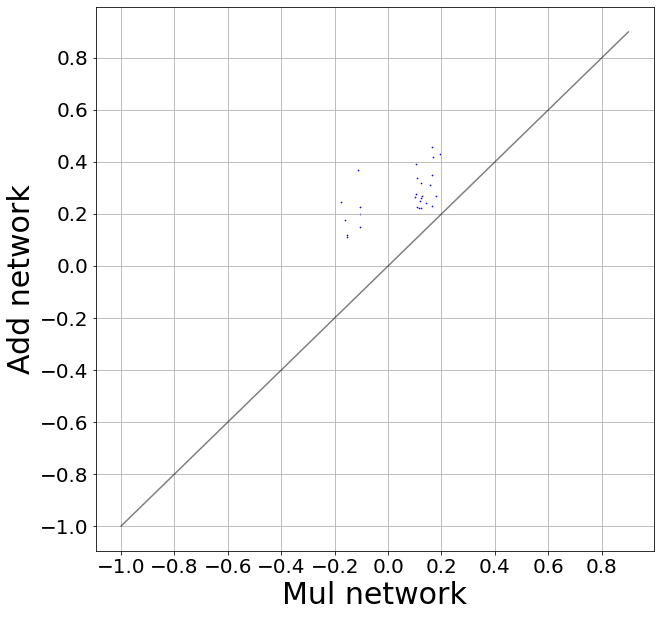

In [127]:
compare_dictionaries(mul_pred, add_pred, xaxis='Mul network', yaxis='Add network')

## Complejo III de mitocondria

In [27]:
complex_III =  ['cytb',
                'qcr1',
                'cyt1',
                'qcr10',
                'qcr2',
                'qcr6',
                'qcr7',
                'qcr8',
                'qcr9',
                'rip1']

In [28]:
def buscar(df, gene):
    df_ = df.loc[(df['Query allele name'].str.contains(gene)) | (df['Array allele name'].str.contains(gene))]
    if len(df_)==0:
        print(f'El gen {gene} no aparece')

In [29]:
for g in complex_III:
    buscar(dfN, g)
# El gen cytb no aparece en dfN

El gen cytb no aparece


In [33]:
dfN = pd.read_table('data/SGA_NxN.txt')
dfN = dfN.dropna()            # Elimino filas con NaN
dfN.reset_index(inplace=True, drop=True)
##################################
dfN['Mul'] = dfN['Double mutant fitness']-dfN['Query single mutant fitness (SMF)']*dfN['Array SMF']         # columna con interacciones mul
dfN['Add'] = dfN['Double mutant fitness']-(dfN['Query single mutant fitness (SMF)']+dfN['Array SMF']-1)     # columna con interacciones add
##################################
std_mul = dfN['Mul'].std()           # Desviaciones estandar de cada columna
std_add = dfN['Add'].std()
##################################
dfN['Query allele name'] = dfN['Query allele name'].map(lambda x: x.split('-')[0])        # Cambio de nombre
dfN['Array allele name'] = dfN['Array allele name'].map(lambda x: x.split('-')[0])
##################################
dfN = dfN.loc[dfN['P-value']<0.05]             # Filtro P-value


########################################################################

qN, aN = df_to_dictionary_splitted(dfN, model='mul', pvalue=0.05)
NxN_mul = join_pcc(qN, aN)

qN, aN = df_to_dictionary_splitted(dfN, model='add', pvalue=0.05)
NxN_add = join_pcc(qN, aN)

########################################################################

for gene in NxN_mul.keys():
    NxN_mul[gene] = dict(filter(lambda x: abs(x[1])>2*std_mul, NxN_mul[gene].items()))

for gene in NxN_add.keys():
    NxN_add[gene] = dict(filter(lambda x: abs(x[1])>2*std_add, NxN_add[gene].items()))

In [49]:
dist0_mul = represent_network(gene_list=complex_III, dic=NxN_mul, dist=0)
dist0_add = represent_network(gene_list=complex_III, dic=NxN_add, dist=0)

dist1_mul = represent_network(gene_list=complex_III, dic=NxN_mul, dist=1)
dist1_add = represent_network(gene_list=complex_III, dic=NxN_add, dist=1)

In [53]:
len(dist0_mul), len(dist0_add), len(dist1_mul), len(dist1_add) # Similar result for both models

(7, 7, 341, 303)

In [58]:
to_table(dist1_mul, path='Complex_III_mul.csv', marked=complex_III)
to_table(dist1_add, path='Complex_III_add.csv', marked=complex_III)